In [2]:
from __future__ import print_function

import argparse
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import QMNIST
# from tqdm import tqdm_notebook as tqdm

In [38]:
import time
import math
from statistics import median, mean, stdev
from datetime import timedelta
from contextlib import ContextDecorator
def benchmark(niter=1, duration=None, batch_size=1):
    
    if duration is not None:
        if not isinstance(duration, (int, float, timedelta)):
            raise TypeError(f"'duration' must be int, float or timedelta, not '{type(duration).__name__}'.")
        if isinstance(duration, timedelta):
            duration = duration.total_seconds()
    def decorator(func):
        def wrapped(*args, **kwargs):
            start_time = time.perf_counter()
            exec_time = 0
            iteration = 0
            
            bench = Benchmark(batch_size=batch_size)
            while (niter and iteration < niter) or (duration and exec_time < duration):
                with bench:
                    func(*args, **kwargs)
                iteration += 1
                exec_time = (time.perf_counter() - start_time)
                
            print(bench)
            
        return wrapped
    return decorator
class Benchmark(ContextDecorator):
    
    def __init__(self, out=False, batch_size=1):
        self.start_time = None
        self.lap_time = None
        self.end_time = None
        self.times = []
        self.batch_size = batch_size
        self.out = out
    
    @property
    def duration(self):
        if self.end_time:
            return timedelta(seconds=(self.end_time - self.start_time))
        else:
            return timedelta()
    
    def __str__(self):
        if len(self.times) == 0:
            return super().__str__()
        
        iteration = len(self.times)
        total_duration = self.duration
        
        if iteration > 1:
            latency_s    = median(self.times)
            latency_mean = mean(self.times)
            latency_std  = stdev(self.times)
        else:
            latency_s    = latency_mean = self.times[0]
            latency_std  = 0.0
            
        fps = self.batch_size * 1 / latency_s
        
        output = [
            f"Count:      {iteration:,} iteration(s)",
            f"Duration:   {total_duration}",
            f"Latency:    {_format_time(latency_s)} ({_format_time(latency_mean)} ± {_format_time(latency_std)})", 
            f"Throughput: {fps:.2f} FPS",
        ]
        return str.join('\n', output)
    
    def __enter__(self):
        if self.lap_time:
            raise RuntimeError("Nested transactions are not supported.")
        
        t = time.perf_counter()
        if not self.start_time:
            self.start_time = t
        self.lap_time = t
        return self
    def __exit__(self, *exc):
        t = time.perf_counter()
        self.end_time = t
        
        elapsed = (t - self.lap_time)
        self.lap_time = None
        self.times.append(elapsed)
        
        if self.out:
            print(self)
        
        return False

def _format_time(timespan, precision=2):
    import math

    if isinstance(timespan, timedelta):
        timespan = timespan.total_seconds()

    if timespan >= 60.0:
        # Idea from http://snipplr.com/view/5713/
        parts = [("days", 3600*24), ("h", 3600), ("m", 60), ("s", 1)]
        time = []
        leftover = timespan
        for (suffix, length) in parts:
            value = int(leftover / length)
            if value > 0:
                leftover = leftover % length
                time.append(f"{value} {suffix}")
            if leftover < 1:
                break
        return " ".join(time)

    units = ["s", "ms", "us","ns"]
    scale = [1, 1e3, 1e6, 1e9]
    order = min(-int(math.floor(math.log10(timespan)) // 3), 3) if timespan > 0.0 else 3

    return "%.*f %s" % (precision, timespan * scale[order], units[order])


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(32,32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout2d(p=0.20)
            )

        self.cnn2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout2d(0.25)
        )

        self.cnn3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
        )

        self.fc = nn.Sequential(
            #全結合層
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.25),
            nn.Linear(128, 10)
        )
 

    def forward(self, x):  

        out = self.cnn1(x)
        out = self.cnn2(out)
        out = self.cnn3(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        out = F.softmax(out, dim = 1)
        return out


In [5]:
def train_model(net, dataloders_dict, criterion, optimizer, num_epochs):
    
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    #初期設定
    #GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス", device)
    #モデルをGPUへ
    net.to(device)
    #ネットワークがある程度固定であれば高速化させる
    torch.backends.cudnn.benchmark = True
    #epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-----------------------------------')

        #epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() #モデルを訓練モードに
            else:
                net.eval() #モデルを検証モードに
            epoch_loss = 0.0 #epochの損失0
            epoch_corrects = 0 #epochの正解数
            #データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm.tqdm(dataloders_dict[phase]):
                #optimizerを初期化
                optimizer.zero_grad()
                #順伝搬(forward)計算
                with torch.set_grad_enabled(phase == 'train'):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)#損失を計算
                    _, preds = torch.max(outputs, 1) #ラベルを予測
                    #訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    #イテレーション結果の計算
                    #lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    #正解の合計数を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            #epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloders_dict[phase].dataset)
            print('{} Loss:{:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
            if phase == 'train':
                train_acc_list.append(epoch_acc)
                train_loss_list.append(epoch_loss)
            else:
                val_acc_list.append(epoch_acc)
                val_loss_list.append(epoch_loss)
    return val_loss_list,train_loss_list, val_acc_list, train_acc_list

In [6]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
from torchvision import transforms
from PIL import Image

import os.path as osp
import glob


#入力画像の処理を行う
#訓練時と推論時で処理が異なる

class ImageTransform():

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize(resize), #リサイズ
                # transforms.RandomRotation(degrees=20), #ランダムに回転
                transforms.ToTensor(), #テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize), #リサイズ
                transforms.ToTensor(), #テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        pahes:'train' or 'val'
        """
        return self.data_transform[phase](img)

class testDataset(data.Dataset):
    '''
    file_list : リスト
        画像パス
    transform: object
        前処理クラスのインスタンス
    phase : 学習化テストか設定する
    '''
    def __init__(self,transform=None, phase='val'):

        self.transform = transforms.Compose([
                        transforms.Resize(32),
                        transforms.CenterCrop(28),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, ), (0.5, ))
                         ])
        self.phase = phase#train or val の指定

        rootpath = "../訓練用画像/tranings/"
        target_path = osp.join(rootpath+'**/*.png')
    
        path_list = []

        for path in glob.glob(target_path):
            path_list.append(path)

        self.file_list = path_list

    def __len__(self):
        #画像の枚数を返す
        return len(self.file_list)
    
    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルの取得
        '''
        #index番目の画像をロード
        img_path = self.file_list[index]
        label = img_path[18]

        img = Image.open(img_path).convert('RGBA')
        r, g, b, a = img.split()
        img = np.asarray(a)
        img = Image.fromarray(img)
        
        img_transformed = self.transform(
            img
        )

        label = torch.tensor(int(label), dtype=torch.int64)
        
        return img_transformed, label

In [27]:
import random
seed = 42
random.seed(seed)  
np.random.seed(seed)  
# PyTorch のRNGを初期化  
torch.manual_seed(seed)

import tensorflow as tf
import torch.utils.data as data
from torch.utils.data import DataLoader


import albumentations as albu

def augment(aug, image):
    return aug(image=image)['image']

def ElTransform(img):
    """
    画像をゆがませる
    """
    img = np.array(img)
    aug = albu.ElasticTransform(alpha=0.5, sigma=0, alpha_affine=0, interpolation=1, border_mode=2, p=0.5)
    img = augment(aug, np.array(img))
    img = Image.fromarray(img)
    return img


rotation_range=10
zoom_range = 0.10
width_shift_range=0.1 
height_shift_range=0.1
train_transform = transforms.Compose([
     transforms.Resize(32),
     transforms.CenterCrop(28),
     transforms.Lambda(ElTransform),
     transforms.RandomAffine(degrees=rotation_range, translate=(width_shift_range, height_shift_range), 
    scale=(1 - zoom_range, 1 + zoom_range)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))
     ])
# test_transform = transforms.Compose([
#     transforms.Resize(32)
#      transforms.CenterCrop(28),
#      transforms.ToTensor(),
#      transforms.Normalize((0.5, ), (0.5, ))
#      ])


trainset = QMNIST(root='./',
                 train=True,
                 download=True,
                 transform=train_transform)


trainloader = DataLoader(trainset,
                         batch_size=1024,
                         shuffle=True,
                         num_workers=0)
testloader =  torch.utils.data.DataLoader(testDataset(), batch_size = 1000, shuffle=False)

dataloders_dict = {"train": trainloader, "val": testloader}

model = Net()
model.load_state_dict(torch.load("./mnist_cnn.pth"))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

val_loss, train_loss, val_acc, train_acc = train_model(model, dataloders_dict, criterion, optimizer, num_epochs=1)


  0%|                                                                                           | 0/59 [00:00<?, ?it/s]

使用デバイス cuda:0
Epoch 1/1
-----------------------------------


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

train Loss:1.4658 Acc: 0.9957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]

val Loss:1.5206 Acc: 0.9440


In [61]:
torch.save(model.state_dict(), "mnist_cnn.pth")

# 検証

In [54]:
model = Net()
model.load_state_dict(torch.load("./mnist_cnn.pth"))
model.to('cuda')

Net(
  (cnn1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.2, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
  )
  (cnn3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features

In [55]:
model.eval()

Net(
  (cnn1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.2, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
  )
  (cnn3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features

In [30]:
class valDataset(data.Dataset):
    def __init__(self):
        path = "../訓練用画像/tests/"
        self.label_dict = []
        with open('../訓練用画像/tests.txt') as f:
            for line in f:
                line = line.replace("\n", "")
                name, label = line.split("/")
                self.label_dict.append(("../訓練用画像/tests/" + name, int(label)))
        self.transform = transforms.Compose([
                        transforms.Resize(32),
                        transforms.CenterCrop(28),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, ), (0.5, ))
                         ])
    def __len__(self):
        #画像の枚数を返す
        return len(self.label_dict)
    
    def __getitem__(self, index):
        img_path, label = self.label_dict[index]
        
        img = Image.open(img_path).convert('RGBA')
        r, g, b, a = img.split()
        img = np.asarray(a)
        img = Image.fromarray(img)
        
        img_transformed = self.transform(
            img
        )

        label = torch.tensor(int(label), dtype=torch.int64)
        
        return img_transformed, label
testloader =  torch.utils.data.DataLoader(testDataset(), batch_size = 1000, shuffle=False)
# testloader =  torch.utils.data.DataLoader(valDataset(), batch_size = 100, shuffle=False)
pred = []
label = []
for i, l in testloader:
    i = i.to('cuda')
    output = model(i)
    _, predicted = torch.max(output.data, 1)
    print(torch.sum(predicted.to('cpu') == l.data))
    pred.append(predicted)
    label.append(l)

tensor(946)


In [31]:
# label[0].to('cpu').numpy()
# pred[0].to('cpu').numpy()

# コンフュージョンマトリックス

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import pandas as pd

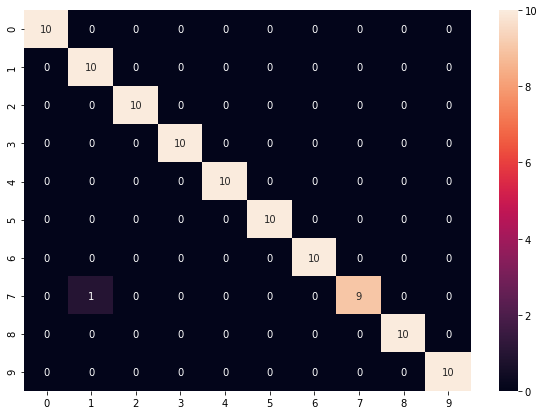

In [33]:
testloader =  torch.utils.data.DataLoader(valDataset(), batch_size = 100, shuffle=False)
pred = []
label = []
for i, l in testloader:
    i = i.to('cuda')
    output = model(i)
    _, predicted = torch.max(output.data, 1)
    pred.append(predicted)
    label.append(l)
confusion = confusion_matrix(label[0].to('cpu').numpy(), pred[0].to('cpu').numpy())
df_cm = pd.DataFrame(confusion,index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

tensor(946)


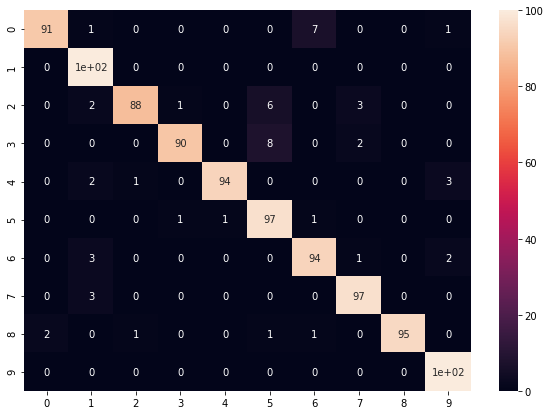

In [34]:
testloader =  torch.utils.data.DataLoader(testDataset(), batch_size = 1000, shuffle=False)

pred = []
label = []
for i, l in testloader:
    i = i.to('cuda')
    output = model(i)
    _, predicted = torch.max(output.data, 1)
    pred.append(predicted)
    print(torch.sum(predicted.to('cpu') == l.data))
    label.append(l)
confusion = confusion_matrix(label[0].to('cpu').numpy(), pred[0].to('cpu').numpy())
df_cm = pd.DataFrame(confusion,index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# ベンチマーク

In [57]:
#import Benchmark

testloader =  torch.utils.data.DataLoader(testDataset(), batch_size = 1, shuffle=False)
testloader =  torch.utils.data.DataLoader(valDataset(), batch_size = 1, shuffle=False)
pred = []
label = []
model.to("cpu")
# @benchmark(duration=5)
# def test():
#     with torch.no_grad():
#         for i, l in testloader:
#             output = model(i)


def test():
    with torch.no_grad():
        bm = Benchmark(out=False)
        for i, l in testloader:
            with bm:
                output = model(i)
    print(bm)
test()

Count:      100 iteration(s)
Duration:   0:00:00.176807
Latency:    1.12 ms (1.14 ms ± 132.06 us)
Throughput: 892.14 FPS


# ONNX　export

In [143]:
from torch.autograd import Variable
import torch.onnx

model = Net()
model.load_state_dict(torch.load("./mnist_cnn.pth"))
model.to('cpu')
x = Variable(torch.randn(1, 1, 28, 28))
torch.onnx.export(model, x, './m.onnx', export_params=True , dynamic_axes={'input': {0: 'sequence1'}, 'output': {0: 'sequence2'}})

# ONNX predict

In [40]:
import onnx
transform = transforms.Compose([
                        transforms.Resize(32),
                        transforms.CenterCrop(28),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, ), (0.5, ))
                         ])
model = onnx.load('./mnist.onnx')
img_list = []
label_list = []
with open('../訓練用画像/tests.txt') as f:
    for line in f:
        line = line.replace("\n", "")
        name, label = line.split("/")
        img = Image.open("../訓練用画像/tests/" + name).convert('RGBA')
        r, g, b, a = img.split()
        
        img = np.asarray(a)
        img = Image.fromarray(img)
        img = transform(img)
        img = img.numpy()
        img_list.append(img)
        label_list.append(int(label))



In [41]:
np.array(img_list).astype("float32").shape

(100, 1, 28, 28)

In [42]:
import onnxruntime

In [43]:
session = onnxruntime.InferenceSession("./m.onnx")
# 入力のラベル名の確認
print("input:")
for session_input in session.get_inputs():
    print(session_input.name, session_input.shape)
# 出力のラベル名の確認
print("output:")
for session_output in session.get_outputs():
    print(session_output.name, session_output.shape)

input:
input.1 [1, 1, 28, 28]
output:
43 [1, 10]


In [44]:
pred = []

for i in np.array(img_list).astype("float32"):
    i = i[None, ...]
    pre = session.run([session_output.name], {session_input.name: i})
    pre = torch.tensor(pre[0], dtype=torch.float32)
    _, out = torch.max(pre, 1)
    pred.append(out.item())

In [45]:
session.run([session_output.name], {session_input.name: np.array(img_list).astype("float32")})

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input.1 for the following indices
 index: 0 Got: 100 Expected: 1
 Please fix either the inputs or the model.

In [46]:

BM = Benchmark(batch_size=1)

def test():
    with BM:
        np.array(img_list).astype("float32"):
            i = i[None, ...]
            pre = session.run([session_output.name], {session_input.name: i})
    print(BM)
#         pre = torch.tensor(pre[0], dtype=torch.float32)
#         _, out = torch.max(pre, 1)
#         pred.append(out.item())
test()

SyntaxError: invalid syntax (<ipython-input-46-2ce0119210d0>, line 5)

In [48]:

def test():
    bm = Benchmark(out=False)
    for i in np.array(img_list).astype("float32"):
        with bm:
            i = i[None, ...]
            pre = session.run([session_output.name], {session_input.name: i})
    print(bm)
    # 推論実行 
test()

Count:      100 iteration(s)
Duration:   0:00:00.015280
Latency:    135.60 us (150.99 us ± 49.95 us)
Throughput: 7374.63 FPS


In [105]:
pred = np.array(pred)
label = np.array(label_list)

In [137]:
import os
import cv2
import sys
import numpy as np
from PIL import Image

In [80]:
img = Image.open("data/tests/25784885.png").resize((28, 28)).convert('RGBA')
img

In [81]:
r, g, b, a = img.split()
img = np.asarray(a)

In [82]:
image = img

In [83]:
inputs = torch.tensor(image, dtype=torch.float32)

In [84]:
inputs.shape

torch.Size([28, 28])

In [94]:
model = Net()
model.load_state_dict(torch.load("./model/mnist_cnn.pth"))
model.to('cuda')

Net(
  (cnn1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.2, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
  )
  (cnn3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=

In [86]:
inputs = test_transform(image)
inputs = inputs[None, ...]
inputs = inputs.to('cuda')

In [87]:
model.eval()
output = model(inputs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [88]:
_, predicted = torch.max(output.data, 1)

In [89]:
predicted.item()

7

In [29]:
import os, sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset
import albumentations as albu


IMG_DIR = '../訓練用画像/tranings/1/01798437.png'


img = cv2.imread(IMG_DIR + 'image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_origin, = img.copy()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(img)

ModuleNotFoundError: No module named 'cv2'